In [1]:
!pip install feature-engine

In [5]:
!pip install imbalanced-learn

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.feature_selection import chi2
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import (
    RandomizedSearchCV,
    train_test_split,
)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    MinMaxScaler,
    Binarizer,
)
from feature_engine.selection import (
    DropDuplicateFeatures,
    DropConstantFeatures,
)
from feature_engine.wrappers import SklearnTransformerWrapper
from imblearn.over_sampling import SMOTENC
from imblearn.under_sampling import (
    InstanceHardnessThreshold,
)
from imblearn.ensemble import (
    RUSBoostClassifier,
    EasyEnsembleClassifier,
)
from imblearn.pipeline import Pipeline as imb_Pipeline

In [8]:
data = pd.read_csv('./data/input/train.csv')
data.head()

,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
0,1,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39205.170000,0
1,3,2,34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49278.030000,0
2,4,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,67333.770000,0
3,8,2,37,0.0,195.0,195.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,64007.970000,0
4,10,2,39,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117310.979016,0


<AxesSubplot:ylabel='TARGET'>

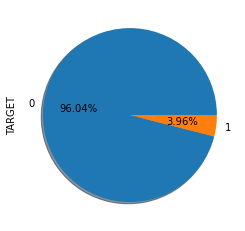

In [14]:
data['TARGET'].value_counts().plot.pie(autopct='%1.2f%%',shadow=True)

In [19]:
X_train, X_test, y_train, y_test = train_test_split(
    data.drop(labels=['ID','TARGET'], axis=1),
    data['TARGET'],
    test_size=0.8,
    random_state=0)

X_train.shape, X_test.shape

((15204, 369), (60816, 369))

In [22]:
y_train.value_counts(normalize=True), y_train.value_counts()

(0    0.960011
 1    0.039989
 Name: TARGET, dtype: float64,
 0    14596
 1      608
 Name: TARGET, dtype: int64)

In [23]:
y_test.value_counts(normalize=True), y_test.value_counts()

(0    0.960537
 1    0.039463
 Name: TARGET, dtype: float64,
 0    58416
 1     2400
 Name: TARGET, dtype: int64)

In [20]:
pipe = Pipeline([
    ('constant', DropConstantFeatures(tol=1)), # drops constant features
    ('duplicated', DropDuplicateFeatures()), # drops duplicates
])

# find features to remove
pipe.fit(X_train, y_train)

Pipeline(steps=[('constant', DropConstantFeatures()),
                ('duplicated', DropDuplicateFeatures())])

In [21]:
len(pipe.named_steps['constant'].features_to_drop_)

57

In [24]:
len(pipe.named_steps['duplicated'].features_to_drop_)

26

In [25]:
print('Number of original variables: ', X_train.shape[1])

# see how with the pipeline we can apply all transformers in sequence
# with one line of code, for each data set
X_train = pipe.transform(X_train)
X_test = pipe.transform(X_test)

print('Number of variables after selection: ', X_train.shape[1])

Number of original variables:  369
Number of variables after selection:  286


In [26]:
sel_ = DropConstantFeatures(tol=0.98)

sel_.fit(X_train)

DropConstantFeatures(tol=0.98)

In [27]:
len(sel_.features_to_drop_)

156

In [29]:
# let's replace values greater than 0 by 1
# for this we need the Binarizer from sklearn with threshold 0

# capture quasi cosntant features in a list
quasi_ = list(sel_.features_to_drop_)

# in order to modify just the quasi-constant features
# we use the sklearn wrapper from feature engine,
# which by the way also returns a dataframe

binarizer_ = SklearnTransformerWrapper(
    transformer = Binarizer(threshold=0),
    variables = quasi_,
)

binarizer_.fit(X_train)

X_train = binarizer_.transform(X_train)
X_test = binarizer_.transform(X_test)

In [30]:
X_train[quasi_[0]].value_counts(normalize=True)

0.0    0.996383
1.0    0.003617
Name: imp_op_var40_comer_ult1, dtype: float64

In [31]:
chi_ = chi2(X_train[quasi_], y_train)

In [32]:
# join feature names and p-values in a dataframe

feat = pd.concat([
    pd.Series(quasi_),
    pd.Series(chi_[1]),
], axis=1,
)

feat.columns = ['feature', 'p_value']

feat.head()

,feature,p_value
0,imp_op_var40_comer_ult1,2.152941e-01
1,imp_op_var40_comer_ult3,4.646291e-02
2,imp_op_var40_efect_ult1,2.262326e-12
3,imp_op_var40_efect_ult3,2.262326e-12
4,imp_op_var40_ult1,5.991313e-02


Text(0.5, 0, 'p value')

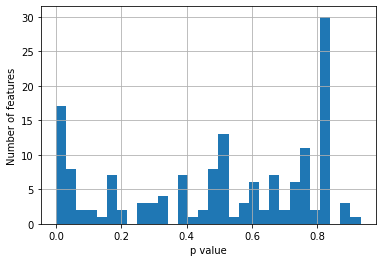

In [33]:
feat['p_value'].hist(bins=30)
plt.ylabel('Number of features')
plt.xlabel('p value')

In [34]:
print('Number of total quasi-constant features: ', len(feat))

feat = feat[feat['p_value']<0.4]

print('Number of non predictive quasi-constant features: ', len(feat))

Number of total quasi-constant features:  156
Number of non predictive quasi-constant features:  55


In [35]:
X_train.drop(labels=feat['feature'], axis=1, inplace=True)
X_test.drop(labels=feat['feature'], axis=1, inplace=True)

X_train.shape

(15204, 231)

In [36]:
# Let's find out how many variables we have with 2, or less than 10 or 20 distinct values

for max_unique in [2, 10, 20]:
    vars_ = [x for x in X_train.columns if X_train[x].nunique()<= max_unique]
    vars_ = len(vars_)
    print(f'{vars_} variables with less than or equal to {max_unique} values')

132 variables with less than or equal to 2 values
161 variables with less than or equal to 10 values
170 variables with less than or equal to 20 values


In [37]:
# set up the gradient boosting classifier with default parameters
gbm = GradientBoostingClassifier(random_state=0)

# determine the hyperparameter space
# we use stats to sample from distributions

param_grid = dict(
    n_estimators=stats.randint(10, 200),
    min_samples_split=stats.uniform(0, 1),
    max_depth=stats.randint(1, 5),
    loss=('deviance', 'exponential'),
    )

# set up the search
search = RandomizedSearchCV(
    gbm, # the model
    param_grid, # hyperparam space
    scoring='roc_auc', # metric to optimize
    cv=2, # I do 2 to speed things up, 5 would be better as the dataset is quite small
    n_iter = 5, # I do 5 to speed things up, but for randomized search 60 has been shown to find the optimal hyperparameters
    random_state=5, # reproducibility
    refit=True, # this fits the model with the best hyperparams to the entire training set after the hyperparam search
)

# find best hyperparameters
search.fit(X_train, y_train)

RandomizedSearchCV(cv=2, estimator=GradientBoostingClassifier(random_state=0),
                   n_iter=5,
                   param_distributions={'loss': ('deviance', 'exponential'),
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000002A1A6C45370>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000002A1A6C45040>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000002A18DCB0070>},
                   random_state=5, scoring='roc_auc')

In [38]:
# the best hyperparameters are stored in an attribute:

search.best_params_

{'loss': 'deviance',
 'max_depth': 2,
 'min_samples_split': 0.48841118879482914,
 'n_estimators': 165}

In [39]:
# Now let's get the benchmark performance on train and test

X_train_preds = search.predict_proba(X_train)[:,1]
X_test_preds = search.predict_proba(X_test)[:,1]

print('Train roc_auc: ', roc_auc_score(y_train, X_train_preds))
print('Test roc_auc: ', roc_auc_score(y_test, X_test_preds))

Train roc_auc:  0.8694858608522883
Test roc_auc:  0.8263806327318999


In [40]:
# set up instance hardness threshold
# the instance hardness is determined based on a gradient boosting machine
# trained on the entire dataset

iht = InstanceHardnessThreshold(
    estimator=gbm, # we pass the model we set up earlier
    sampling_strategy='auto',  # undersamples only the majority class
    random_state=1,
    cv=2,  # cross validation fold, 2 to speed things up.
)

# resample
X_resampled, y_resampled = iht.fit_resample(X_train, y_train)

# shape of original data and data after resampling
X_train.shape, X_resampled.shape

((15204, 231), (1233, 231))

In [41]:
# check the resampled target
y_resampled.value_counts(normalize=True)

0    0.506894
1    0.493106
Name: TARGET, dtype: float64

In [42]:
# train model while finding best hyperparameters

search.fit(X_resampled, y_resampled)

RandomizedSearchCV(cv=2, estimator=GradientBoostingClassifier(random_state=0),
                   n_iter=5,
                   param_distributions={'loss': ('deviance', 'exponential'),
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000002A1A6C45370>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000002A1A6C45040>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000002A18DCB0070>},
                   random_state=5, scoring='roc_auc')

In [43]:
# the best hyperparameters are stored in an attribute:

search.best_params_

{'loss': 'deviance',
 'max_depth': 3,
 'min_samples_split': 0.48663799685836207,
 'n_estimators': 153}

In [44]:
# Now let's get the performance on train and test

X_train_preds = search.predict_proba(X_resampled)[:,1]
X_test_preds = search.predict_proba(X_test)[:,1]

print('Train roc_auc: ', roc_auc_score(y_resampled, X_train_preds))
print('Test roc_auc: ', roc_auc_score(y_test, X_test_preds))

Train roc_auc:  0.9999999999999999
Test roc_auc:  0.7915799110403543


In [45]:
# we need to capture the index of the discrete variables

# make list of discrete variables
cat_vars = [var for var in X_train.columns if X_train[var].nunique() <= 10]

# capture the index in the dataframe columns
cat_vars_index = [cat_vars.index(x) for x in cat_vars]

cat_vars_index[0:6]

[0, 1, 2, 3, 4, 5]

In [46]:
smnc = SMOTENC(
    sampling_strategy='auto', # samples only the minority class
    random_state=0,  # for reproducibility
    k_neighbors=3,
    categorical_features=cat_vars_index # indeces of the columns of categorical variables
)  

# because SMOTE uses KNN, and KNN is sensible to variable magnitude, we re-scale the data
X_resampled, y_resampled = smnc.fit_resample(MinMaxScaler().fit_transform(X_train), y_train)

X_train.shape, X_resampled.shape

((15204, 231), (29192, 231))

In [48]:
y_resampled.value_counts(normalize=True)

0    0.5
1    0.5
Name: TARGET, dtype: float64

In [49]:
# train the model while finding best hyperparameters

search.fit(X_resampled, y_resampled)

RandomizedSearchCV(cv=2, estimator=GradientBoostingClassifier(random_state=0),
                   n_iter=5,
                   param_distributions={'loss': ('deviance', 'exponential'),
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000002A1A6C45370>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000002A1A6C45040>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000002A18DCB0070>},
                   random_state=5, scoring='roc_auc')

In [50]:
# the best hyperparameters are stored in an attribute:

search.best_params_

{'loss': 'deviance',
 'max_depth': 2,
 'min_samples_split': 0.1583098677126512,
 'n_estimators': 185}

In [51]:
# Now let's get the performance on train and test

X_train_preds = search.predict_proba(X_resampled)[:,1]
X_test_preds = search.predict_proba(X_test)[:,1]

print('Train roc_auc: ', roc_auc_score(y_resampled, X_train_preds))
print('Test roc_auc: ', roc_auc_score(y_test, X_test_preds))

Train roc_auc:  0.9300278376383503
Test roc_auc:  0.7021328381778965


In [52]:
# set up the RUSBoost ensemble model
rusboost = RUSBoostClassifier(
        base_estimator=None,
        n_estimators=20,
        learning_rate=1.0,
        sampling_strategy='auto',
        random_state=2909,
    )

# set up the hyperparameter space
# the default implementation as 2 hyperparameters to optimize

param_grid = dict(
    n_estimators=stats.randint(10, 200),
    learning_rate=stats.uniform(0.0001, 1),
    )

# set up the search
search = RandomizedSearchCV(
    rusboost, # the model
    param_grid, # hyperparam space
    scoring='roc_auc', # metric to optimize
    cv=2, # I do 2 to speed things up, 5 would be better as the dataset is quite small
    n_iter = 5, # I do 10 to speed things up, but for randomized search 60 has been shown to find the optimal hyperparameters
    random_state=10, # reproducibility
    refit=True, # this fits the model with the best hyperparams to the entire training set after the hyperparam search
)

# find best hyperparameters
# using the original data (without resampling)
search.fit(X_train, y_train)

RandomizedSearchCV(cv=2,
                   estimator=RUSBoostClassifier(n_estimators=20,
                                                random_state=2909),
                   n_iter=5,
                   param_distributions={'learning_rate': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000002A18C9FB970>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000002A18C717FD0>},
                   random_state=10, scoring='roc_auc')

In [53]:
# the best hyperparameters are stored in an attribute:

search.best_params_

{'learning_rate': 0.19816286475962397, 'n_estimators': 18}

In [54]:
# Now let's get the performance on train and test

X_train_preds = search.predict_proba(X_train)[:,1]
X_test_preds = search.predict_proba(X_test)[:,1]

print('Train roc_auc: ', roc_auc_score(y_train, X_train_preds))
print('Test roc_auc: ', roc_auc_score(y_test, X_test_preds))

Train roc_auc:  0.8302714627114854
Test roc_auc:  0.8093590333413221


In [55]:
easy = EasyEnsembleClassifier(
        n_estimators=20,
        sampling_strategy='auto',
        random_state=2909,
    )

# set up the hyperparameter space
# the default implementation as 1 hyperparameters to optimize

param_grid = dict(
    n_estimators=stats.randint(10, 200),
    )

# set up the search
search = RandomizedSearchCV(
    easy, # the model
    param_grid, # hyperparam space
    scoring='roc_auc', # metric to optimize
    cv=2, # I do 2 to speed things up, 5 would be better as the dataset is quite small
    n_iter = 5, # I do 10 to speed things up, but for randomized search 60 has been shown to find the optimal hyperparameters
    random_state=10, # reproducibility
    refit=True, # this fits the model with the best hyperparams to the entire training set after the hyperparam search
)

# find best hyperparameters
# using the original data (without resampling)
search.fit(X_train, y_train)

RandomizedSearchCV(cv=2,
                   estimator=EasyEnsembleClassifier(n_estimators=20,
                                                    random_state=2909),
                   n_iter=5,
                   param_distributions={'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000002A18CA34A60>},
                   random_state=10, scoring='roc_auc')

In [ ]:
# the best hyperparameters are stored in an attribute:

search.best_params_

In [ ]:
# Now let's get the performance on train and test

X_train_preds = search.predict_proba(X_train)[:,1]
X_test_preds = search.predict_proba(X_test)[:,1]

print('Train roc_auc: ', roc_auc_score(y_train, X_train_preds))
print('Test roc_auc: ', roc_auc_score(y_test, X_test_preds))

In [ ]:
# set up the gradient boosting classifier with default parameters
gbm = GradientBoostingClassifier(random_state=0)

# determine the hyperparameter space
# we use stats to sample from distributions

param_grid = dict(
    n_estimators=stats.randint(10, 200),
    min_samples_split=stats.uniform(0, 1),
    max_depth=stats.randint(1, 5),
    loss=('deviance', 'exponential'),
    )

# set up the search
search = RandomizedSearchCV(
    gbm, # the model
    param_grid, # hyperparam space
    scoring='roc_auc', # metric to optimize
    cv=2, # I do 2 to speed things up, 5 would be better as the dataset is quite small
    n_iter = 5, # I do 10 to speed things up, but for randomized search 60 has been shown to find the optimal hyperparameters
    random_state=10, # reproducibility
    refit=True, # this fits the model with the best hyperparams to the entire training set after the hyperparam search
)

# we have an imbalance of 95 to 5, so we use those as weights
sample_weight = np.where(y_train==1, 95, 5)

# find best hyperparameters
search.fit(X_train, y_train, sample_weight)

In [ ]:
# the best hyperparameters are stored in an attribute:

search.best_params_

In [ ]:
# Now let's get the performance on train and test

X_train_preds = search.predict_proba(X_train)[:,1]
X_test_preds = search.predict_proba(X_test)[:,1]

print('Train roc_auc: ', roc_auc_score(y_train, X_train_preds))
print('Test roc_auc: ', roc_auc_score(y_test, X_test_preds))